In [2]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import datetime
import seaborn as sns
import plotly as plt

In [3]:
from IPython.core.display import HTML

In [5]:
#imports the raw data in chunks. SQL export could not accomodate one CSV dump

USMTO1 = pd.DataFrame.from_csv(r'C:\Users\bcroarkin\Documents\AMT\Education\Springboard\Data\USMTO1.csv', index_col = False)
USMTO2 = pd.DataFrame.from_csv(r'C:\Users\bcroarkin\Documents\AMT\Education\Springboard\Data\USMTO2.csv', index_col = False)
USMTO3 = pd.DataFrame.from_csv(r'C:\Users\bcroarkin\Documents\AMT\Education\Springboard\Data\USMTO3.csv', index_col = False)
USMTO4 = pd.DataFrame.from_csv(r'C:\Users\bcroarkin\Documents\AMT\Education\Springboard\Data\USMTO4.csv', index_col = False)
USMTO5 = pd.DataFrame.from_csv(r'C:\Users\bcroarkin\Documents\AMT\Education\Springboard\Data\USMTO5.csv', index_col = False)

In [7]:
#imports raw data for S&P 500 values and Industrial Production

SP_500 = pd.DataFrame.from_csv(r'C:\Users\bcroarkin\Documents\AMT\Education\Springboard\Data\SP_500.csv', index_col = False)

In [8]:
USMTO_WHOLE = USMTO1.append(USMTO2).append(USMTO3).append(USMTO4).append(USMTO5)

In [9]:
#merges external data with USMTO data

USMTO_WHOLE = USMTO_WHOLE.merge(SP_500, how='inner', on = ['EntryMonth', 'EntryYear'])

In [10]:
#format order date to datetime to prepare for analysis

USMTO_WHOLE['OrderDateFormatted'] = pd.to_datetime(USMTO_WHOLE.OrderDate)

In [11]:
#format changed date to datetime to prepare for analysis

USMTO_WHOLE['ChangedDateFormatted'] = pd.to_datetime(USMTO_WHOLE.ChangedDate)

In [12]:
#format submit date to datetime to prepare for analysis

USMTO_WHOLE['SubmitDateFormatted'] = pd.to_datetime(USMTO_WHOLE.SubmitDate.fillna(''))

In [13]:
#more formatting to get Order Date at End of Month

USMTO_WHOLE['hyphen'] = "-"

USMTO_WHOLE['OrderDateEOM'] = (USMTO_WHOLE.EntryYear.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.EntryMonth.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.OrderDateFormatted.dt.days_in_month.astype(str))

In [14]:
#format OrderDateEOM to datetime

USMTO_WHOLE['OrderDateEOM'] = pd.to_datetime(USMTO_WHOLE['OrderDateEOM'])

In [15]:
#create column DaysLate which indicates how many days late the order was submitted

USMTO_WHOLE['DaysLate'] = (USMTO_WHOLE['SubmitDateFormatted'] - USMTO_WHOLE['OrderDateEOM']).dt.days - 10

In [16]:
#fill all NaN with "0" -> count=141

USMTO_WHOLE['DaysLate'] = USMTO_WHOLE['DaysLate'].fillna('0')

In [17]:
#cast DaysLate and TotalSale as float64

USMTO_WHOLE['DaysLate'] = pd.to_numeric(USMTO_WHOLE['DaysLate'])
USMTO_WHOLE['TotalSale'] = (USMTO_WHOLE['TotalSale'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [18]:
#drop un-needed columns

USMTO_WHOLE = USMTO_WHOLE.drop('SubmitDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('OrderDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('ChangedDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsCancel', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('CancelOrderID', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('hyphen', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsMatch', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsIgnore', axis=1)

In [19]:
#creates columns IsEmailOne, IsEmailTwo, IsCall indicating when reminders are made for a member to submit

USMTO_WHOLE['IsEmailOne'] = USMTO_WHOLE['DaysLate'] >= 1
USMTO_WHOLE.IsEmailOne = USMTO_WHOLE.IsEmailOne.astype('int')       

USMTO_WHOLE['IsEmailTwo'] = USMTO_WHOLE['DaysLate'] >= 5
USMTO_WHOLE.IsEmailTwo = USMTO_WHOLE.IsEmailTwo.astype('int')    

USMTO_WHOLE['IsCall'] = USMTO_WHOLE['DaysLate'] >= 10
USMTO_WHOLE.IsCall = USMTO_WHOLE.IsCall.astype('int')

USMTO_WHOLE['IsBackfill'] = USMTO_WHOLE['DaysLate'] >= 90
USMTO_WHOLE.IsBackfill = USMTO_WHOLE.IsBackfill.astype('int')

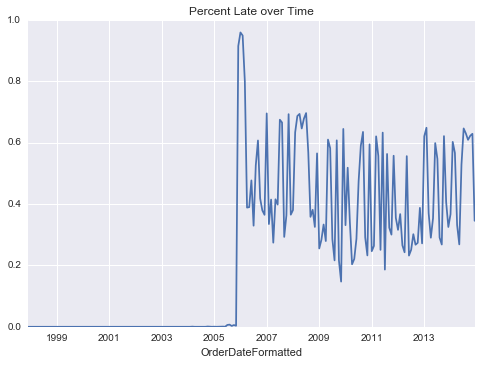

In [20]:
#shows the need to truncate data set

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsEmailOne'].mean().plot(kind = 'line', title = 'Percent Late over Time')

In [21]:
#tosses the former half of data which may not be relevant

USMTO_WHOLE = USMTO_WHOLE[(USMTO_WHOLE.OrderDateFormatted >= '2006-05-01')]

In [22]:
USMTO_WHOLE.columns

Index([u'OrderID', u'AAID', u'NAICSID', u'CustomerZipCode',
       u'ShippingCountryID', u'ShippingZipCode', u'Units', u'TotalSale',
       u'CreatedBy', u'CreateDate', u'ChangedBy', u'IsSubmitted',
       u'TopCategoryName', u'SubCategory', u'SubCategoryName', u'Description',
       u'MachineCode', u'EntryMonth', u'EntryYear', u'Date', u'Close', u'IP',
       u'OrderDateFormatted', u'ChangedDateFormatted', u'SubmitDateFormatted',
       u'OrderDateEOM', u'DaysLate', u'IsEmailOne', u'IsEmailTwo', u'IsCall',
       u'IsBackfill'],
      dtype='object')

In [23]:
USMTO_WHOLE['SaleIndex'] = USMTO_WHOLE['TotalSale']*100/151158.9

In [24]:
TopCategoryPct = USMTO_WHOLE.groupby(['TopCategoryName','OrderDateFormatted'])['TotalSale'].sum()
TopCategoryPct


TopCategoryName          OrderDateFormatted
METAL CUTTING EQUIPMENT  2006-05-01            4.376906e+08
                         2006-06-01            4.440146e+08
                         2006-07-01            3.967124e+08
                         2006-08-01            4.328811e+08
                         2006-09-01            5.906916e+08
                         2006-10-01            4.990681e+08
                         2006-11-01            4.642359e+08
                         2006-12-01            4.274831e+08
                         2007-01-01            4.209134e+08
                         2007-02-01            3.924873e+08
                         2007-03-01            5.420149e+08
                         2007-04-01            3.959328e+08
                         2007-05-01            4.381443e+08
                         2007-06-01            4.790465e+08
                         2007-07-01            3.699615e+08
                         2007-08-01            5.006092e

In [267]:
TopCategoryTotal = USMTO_WHOLE.groupby(by=['TopCategoryName','OrderDateFormatted'])['TotalSale'].sum()
USMTO_WHOLE['TopCategoryTotal'] = TopCategoryTotal.reset_index(level=0, drop=True)

ValueError: cannot reindex from a duplicate axis

In [221]:
TopCategoryPct = USMTO_WHOLE.groupby(['TopCategoryName','OrderDateFormatted'])['TotalSale'].sum()
TopCategoryPct.reset_index(level=1, inplace=True)
TopCategoryPct.reset_index(level=1, inplace=True)

TypeError: Cannot reset_index inplace on a Series to create a DataFrame

In [25]:
USMTO_WHOLE.columns

Index([u'OrderID', u'AAID', u'NAICSID', u'CustomerZipCode',
       u'ShippingCountryID', u'ShippingZipCode', u'Units', u'TotalSale',
       u'CreatedBy', u'CreateDate', u'ChangedBy', u'IsSubmitted',
       u'TopCategoryName', u'SubCategory', u'SubCategoryName', u'Description',
       u'MachineCode', u'EntryMonth', u'EntryYear', u'Date', u'Close', u'IP',
       u'OrderDateFormatted', u'ChangedDateFormatted', u'SubmitDateFormatted',
       u'OrderDateEOM', u'DaysLate', u'IsEmailOne', u'IsEmailTwo', u'IsCall',
       u'IsBackfill', u'SaleIndex'],
      dtype='object')

In [69]:
USMTO_WHOLE.head()

,OrderID,AAID,NAICSID,CustomerZipCode,ShippingCountryID,ShippingZipCode,Units,TotalSale,CreatedBy,CreateDate,...,OrderDateFormatted,ChangedDateFormatted,SubmitDateFormatted,OrderDateEOM,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,SaleIndex
0,5f545239-d6cb-4bdb-a031-005965d53dff,100290,223,48162,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48162,1,67405.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:29:17 AM,...,2014-01-01,2014-02-19 08:29:17,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,44.592148
1,7ea1df73-7202-4994-8b9b-01701fc0eff5,100290,218,48726,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48726,1,69995.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:22:46 AM,...,2014-01-01,2014-02-19 08:22:46,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,46.305576
2,a0cecbb0-0c70-4435-b90c-1a40886b22c7,100290,193,49004,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49004,1,209217.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:07:57 AM,...,2014-01-01,2014-02-19 08:07:57,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,138.408655
3,262406fb-462d-4d7e-8717-23104d817c73,100290,253,48212,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48212,1,203526.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:03:20 AM,...,2014-01-01,2014-02-19 08:03:20,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,134.643742
4,afbed794-b70a-44df-9bbc-4c1078733462,100290,526,48309,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48309,1,177569.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:24:07 AM,...,2014-01-01,2014-02-19 08:24:07,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,117.471747


In [243]:
USMTO_WHOLE['TopCategory'] = USMTO_WHOLE['TopCategoryName']

In [244]:
USMTO_WHOLE.replace({'TopCategory' : { 'METAL CUTTING EQUIPMENT' : 1, 'METAL FORMING & FABRICATING EQUIPMENT' : 2, 'OTHER MFG. TECHNOLOGY' : 3}})

,OrderID,AAID,NAICSID,CustomerZipCode,ShippingCountryID,ShippingZipCode,Units,TotalSale,CreatedBy,CreateDate,...,ChangedDateFormatted,SubmitDateFormatted,OrderDateEOM,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,SaleIndex,TopCategory
0,5f545239-d6cb-4bdb-a031-005965d53dff,100290,223,48162,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48162,1,67405.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:29:17 AM,...,2014-02-19 08:29:17,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,44.592148,1
1,7ea1df73-7202-4994-8b9b-01701fc0eff5,100290,218,48726,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48726,1,69995.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:22:46 AM,...,2014-02-19 08:22:46,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,46.305576,1
2,a0cecbb0-0c70-4435-b90c-1a40886b22c7,100290,193,49004,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49004,1,209217.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:07:57 AM,...,2014-02-19 08:07:57,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,138.408655,1
3,262406fb-462d-4d7e-8717-23104d817c73,100290,253,48212,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48212,1,203526.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:03:20 AM,...,2014-02-19 08:03:20,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,134.643742,1
4,afbed794-b70a-44df-9bbc-4c1078733462,100290,526,48309,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48309,1,177569.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:24:07 AM,...,2014-02-19 08:24:07,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,117.471747,1
5,4c53ffc6-b8d7-4431-ac4a-518d0d4caf12,100290,587,49022,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49022,1,27005.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:26:15 AM,...,2014-02-19 08:26:15,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,17.865306,1
6,9ffbb48a-f62c-4fc7-b296-6804e7348e06,100290,587,49002,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49002,1,32065.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:28:16 AM,...,2014-02-19 08:28:16,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,21.212777,1
7,b8fc73a4-f3cb-4049-85a3-6cea8c32eb1c,100290,221,49087,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49087,1,93425.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:12:33 AM,...,2014-02-19 08:12:33,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,61.805822,1
8,d3bea957-ea95-4a05-b284-721e8998655f,100290,205,48661,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48661,1,72578.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:06:45 AM,...,2014-02-19 08:06:45,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,48.014374,1
9,cd1d5bf8-6f0b-4d1d-b938-7a24d2563ab4,100290,218,48211,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48211,1,74077.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:21:25 AM,...,2014-02-19 08:21:25,2014-02-19 08:31:27,2014-01-31,9.0,1,1,0,0,49.006046,1


In [269]:
USMTO_WHOLE['MetalCuttingScore'] = USMTO_WHOLE['TopCategoryName']

In [246]:
USMTO_WHOLE['MetalFormingScore'] = USMTO_WHOLE['TopCategoryName']

In [247]:
USMTO_WHOLE['OtherMfgScore'] = USMTO_WHOLE['TopCategoryName']

In [250]:
USMTO_WHOLE.columns

Index([u'OrderID', u'AAID', u'NAICSID', u'CustomerZipCode',
       u'ShippingCountryID', u'ShippingZipCode', u'Units', u'TotalSale',
       u'CreatedBy', u'CreateDate', u'ChangedBy', u'IsSubmitted',
       u'TopCategoryName', u'SubCategory', u'SubCategoryName', u'Description',
       u'MachineCode', u'EntryMonth', u'EntryYear', u'Date', u'Close', u'IP',
       u'OrderDateFormatted', u'ChangedDateFormatted', u'SubmitDateFormatted',
       u'OrderDateEOM', u'DaysLate', u'IsEmailOne', u'IsEmailTwo', u'IsCall',
       u'IsBackfill', u'SaleIndex', u'TopCategory', u'MetalCuttingScore',
       u'MetalFormingScore', u'OtherMfgScore'],
      dtype='object')

In [270]:
USMTO_WHOLE.head(20)

,OrderID,AAID,NAICSID,CustomerZipCode,ShippingCountryID,ShippingZipCode,Units,TotalSale,CreatedBy,CreateDate,...,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,SaleIndex,TopCategory,MetalCuttingScore,MetalFormingScore,OtherMfgScore
0,5f545239-d6cb-4bdb-a031-005965d53dff,100290,223,48162,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48162,1,67405.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:29:17 AM,...,9.0,1,1,0,0,44.592148,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
1,7ea1df73-7202-4994-8b9b-01701fc0eff5,100290,218,48726,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48726,1,69995.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:22:46 AM,...,9.0,1,1,0,0,46.305576,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
2,a0cecbb0-0c70-4435-b90c-1a40886b22c7,100290,193,49004,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49004,1,209217.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:07:57 AM,...,9.0,1,1,0,0,138.408655,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
3,262406fb-462d-4d7e-8717-23104d817c73,100290,253,48212,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48212,1,203526.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:03:20 AM,...,9.0,1,1,0,0,134.643742,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
4,afbed794-b70a-44df-9bbc-4c1078733462,100290,526,48309,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48309,1,177569.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:24:07 AM,...,9.0,1,1,0,0,117.471747,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
5,4c53ffc6-b8d7-4431-ac4a-518d0d4caf12,100290,587,49022,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49022,1,27005.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:26:15 AM,...,9.0,1,1,0,0,17.865306,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
6,9ffbb48a-f62c-4fc7-b296-6804e7348e06,100290,587,49002,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49002,1,32065.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:28:16 AM,...,9.0,1,1,0,0,21.212777,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
7,b8fc73a4-f3cb-4049-85a3-6cea8c32eb1c,100290,221,49087,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49087,1,93425.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:12:33 AM,...,9.0,1,1,0,0,61.805822,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
8,d3bea957-ea95-4a05-b284-721e8998655f,100290,205,48661,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48661,1,72578.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:06:45 AM,...,9.0,1,1,0,0,48.014374,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
9,cd1d5bf8-6f0b-4d1d-b938-7a24d2563ab4,100290,218,48211,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48211,1,74077.0,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:21:25 AM,...,9.0,1,1,0,0,49.006046,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT


In [271]:
USMTO_WHOLE.replace({'TopCategory' : {'METAL CUTTING EQUIPMENT' : 1, 'METAL FORMING & FABRICATING EQUIPMENT' : 2, 'OTHER MFG. TECHNOLOGY' : 3}})

,OrderID,AAID,NAICSID,CustomerZipCode,ShippingCountryID,ShippingZipCode,Units,TotalSale,CreatedBy,CreateDate,...,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,SaleIndex,TopCategory,MetalCuttingScore,MetalFormingScore,OtherMfgScore
0,5f545239-d6cb-4bdb-a031-005965d53dff,100290,223,48162,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48162,1,67405.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:29:17 AM,...,9.0,1,1,0,0,44.592148,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
1,7ea1df73-7202-4994-8b9b-01701fc0eff5,100290,218,48726,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48726,1,69995.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:22:46 AM,...,9.0,1,1,0,0,46.305576,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
2,a0cecbb0-0c70-4435-b90c-1a40886b22c7,100290,193,49004,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49004,1,209217.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:07:57 AM,...,9.0,1,1,0,0,138.408655,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
3,262406fb-462d-4d7e-8717-23104d817c73,100290,253,48212,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48212,1,203526.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:03:20 AM,...,9.0,1,1,0,0,134.643742,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
4,afbed794-b70a-44df-9bbc-4c1078733462,100290,526,48309,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48309,1,177569.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:24:07 AM,...,9.0,1,1,0,0,117.471747,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
5,4c53ffc6-b8d7-4431-ac4a-518d0d4caf12,100290,587,49022,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49022,1,27005.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:26:15 AM,...,9.0,1,1,0,0,17.865306,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
6,9ffbb48a-f62c-4fc7-b296-6804e7348e06,100290,587,49002,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49002,1,32065.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:28:16 AM,...,9.0,1,1,0,0,21.212777,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
7,b8fc73a4-f3cb-4049-85a3-6cea8c32eb1c,100290,221,49087,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49087,1,93425.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:12:33 AM,...,9.0,1,1,0,0,61.805822,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
8,d3bea957-ea95-4a05-b284-721e8998655f,100290,205,48661,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48661,1,72578.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:06:45 AM,...,9.0,1,1,0,0,48.014374,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
9,cd1d5bf8-6f0b-4d1d-b938-7a24d2563ab4,100290,218,48211,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48211,1,74077.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:21:25 AM,...,9.0,1,1,0,0,49.006046,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT


In [273]:
for col in USMTO_WHOLE:
    print col, USMTO_WHOLE[col].dtypes

OrderID object
AAID int64
NAICSID int64
CustomerZipCode object
ShippingCountryID object
ShippingZipCode object
Units int64
TotalSale float64
CreatedBy object
CreateDate object
ChangedBy object
IsSubmitted int64
TopCategoryName object
SubCategory int64
SubCategoryName object
Description object
MachineCode float64
EntryMonth int64
EntryYear int64
Date object
Close float64
IP float64
OrderDateFormatted datetime64[ns]
ChangedDateFormatted datetime64[ns]
SubmitDateFormatted datetime64[ns]
OrderDateEOM datetime64[ns]
DaysLate float64
IsEmailOne int32
IsEmailTwo int32
IsCall int32
IsBackfill int32
SaleIndex float64
TopCategory object
MetalCuttingScore object
MetalFormingScore object
OtherMfgScore object


In [252]:
USMTO_WHOLE.replace({'MetalCuttingScore' : { 'METAL CUTTING EQUIPMENT' : 1, 'METAL FORMING & FABRICATING EQUIPMENT' : 0, 'OTHER MFG. TECHNOLOGY' : 0}})

,OrderID,AAID,NAICSID,CustomerZipCode,ShippingCountryID,ShippingZipCode,Units,TotalSale,CreatedBy,CreateDate,...,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,SaleIndex,TopCategory,MetalCuttingScore,MetalFormingScore,OtherMfgScore
0,5f545239-d6cb-4bdb-a031-005965d53dff,100290,223,48162,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48162,1,67405.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:29:17 AM,...,9.0,1,1,0,0,44.592148,METAL CUTTING EQUIPMENT,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
1,7ea1df73-7202-4994-8b9b-01701fc0eff5,100290,218,48726,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48726,1,69995.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:22:46 AM,...,9.0,1,1,0,0,46.305576,METAL CUTTING EQUIPMENT,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
2,a0cecbb0-0c70-4435-b90c-1a40886b22c7,100290,193,49004,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49004,1,209217.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:07:57 AM,...,9.0,1,1,0,0,138.408655,METAL CUTTING EQUIPMENT,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
3,262406fb-462d-4d7e-8717-23104d817c73,100290,253,48212,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48212,1,203526.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:03:20 AM,...,9.0,1,1,0,0,134.643742,METAL CUTTING EQUIPMENT,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
4,afbed794-b70a-44df-9bbc-4c1078733462,100290,526,48309,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48309,1,177569.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:24:07 AM,...,9.0,1,1,0,0,117.471747,METAL CUTTING EQUIPMENT,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
5,4c53ffc6-b8d7-4431-ac4a-518d0d4caf12,100290,587,49022,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49022,1,27005.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:26:15 AM,...,9.0,1,1,0,0,17.865306,METAL CUTTING EQUIPMENT,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
6,9ffbb48a-f62c-4fc7-b296-6804e7348e06,100290,587,49002,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49002,1,32065.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:28:16 AM,...,9.0,1,1,0,0,21.212777,METAL CUTTING EQUIPMENT,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
7,b8fc73a4-f3cb-4049-85a3-6cea8c32eb1c,100290,221,49087,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49087,1,93425.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:12:33 AM,...,9.0,1,1,0,0,61.805822,METAL CUTTING EQUIPMENT,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
8,d3bea957-ea95-4a05-b284-721e8998655f,100290,205,48661,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48661,1,72578.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:06:45 AM,...,9.0,1,1,0,0,48.014374,METAL CUTTING EQUIPMENT,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT
9,cd1d5bf8-6f0b-4d1d-b938-7a24d2563ab4,100290,218,48211,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48211,1,74077.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:21:25 AM,...,9.0,1,1,0,0,49.006046,METAL CUTTING EQUIPMENT,1,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT


In [253]:
USMTO_WHOLE.replace({'MetalFormingScore' : { 'METAL CUTTING EQUIPMENT' : 0, 'METAL FORMING & FABRICATING EQUIPMENT' : 1, 'OTHER MFG. TECHNOLOGY' : 0}})


,OrderID,AAID,NAICSID,CustomerZipCode,ShippingCountryID,ShippingZipCode,Units,TotalSale,CreatedBy,CreateDate,...,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,SaleIndex,TopCategory,MetalCuttingScore,MetalFormingScore,OtherMfgScore
0,5f545239-d6cb-4bdb-a031-005965d53dff,100290,223,48162,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48162,1,67405.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:29:17 AM,...,9.0,1,1,0,0,44.592148,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0,METAL CUTTING EQUIPMENT
1,7ea1df73-7202-4994-8b9b-01701fc0eff5,100290,218,48726,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48726,1,69995.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:22:46 AM,...,9.0,1,1,0,0,46.305576,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0,METAL CUTTING EQUIPMENT
2,a0cecbb0-0c70-4435-b90c-1a40886b22c7,100290,193,49004,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49004,1,209217.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:07:57 AM,...,9.0,1,1,0,0,138.408655,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0,METAL CUTTING EQUIPMENT
3,262406fb-462d-4d7e-8717-23104d817c73,100290,253,48212,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48212,1,203526.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:03:20 AM,...,9.0,1,1,0,0,134.643742,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0,METAL CUTTING EQUIPMENT
4,afbed794-b70a-44df-9bbc-4c1078733462,100290,526,48309,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48309,1,177569.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:24:07 AM,...,9.0,1,1,0,0,117.471747,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0,METAL CUTTING EQUIPMENT
5,4c53ffc6-b8d7-4431-ac4a-518d0d4caf12,100290,587,49022,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49022,1,27005.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:26:15 AM,...,9.0,1,1,0,0,17.865306,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0,METAL CUTTING EQUIPMENT
6,9ffbb48a-f62c-4fc7-b296-6804e7348e06,100290,587,49002,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49002,1,32065.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:28:16 AM,...,9.0,1,1,0,0,21.212777,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0,METAL CUTTING EQUIPMENT
7,b8fc73a4-f3cb-4049-85a3-6cea8c32eb1c,100290,221,49087,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49087,1,93425.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:12:33 AM,...,9.0,1,1,0,0,61.805822,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0,METAL CUTTING EQUIPMENT
8,d3bea957-ea95-4a05-b284-721e8998655f,100290,205,48661,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48661,1,72578.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:06:45 AM,...,9.0,1,1,0,0,48.014374,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0,METAL CUTTING EQUIPMENT
9,cd1d5bf8-6f0b-4d1d-b938-7a24d2563ab4,100290,218,48211,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48211,1,74077.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:21:25 AM,...,9.0,1,1,0,0,49.006046,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0,METAL CUTTING EQUIPMENT


In [254]:
USMTO_WHOLE.replace({'OtherMfgScore' : { 'METAL CUTTING EQUIPMENT' : 0, 'METAL FORMING & FABRICATING EQUIPMENT' : 1, 'OTHER MFG. TECHNOLOGY' : 0}})

,OrderID,AAID,NAICSID,CustomerZipCode,ShippingCountryID,ShippingZipCode,Units,TotalSale,CreatedBy,CreateDate,...,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,SaleIndex,TopCategory,MetalCuttingScore,MetalFormingScore,OtherMfgScore
0,5f545239-d6cb-4bdb-a031-005965d53dff,100290,223,48162,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48162,1,67405.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:29:17 AM,...,9.0,1,1,0,0,44.592148,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0
1,7ea1df73-7202-4994-8b9b-01701fc0eff5,100290,218,48726,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48726,1,69995.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:22:46 AM,...,9.0,1,1,0,0,46.305576,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0
2,a0cecbb0-0c70-4435-b90c-1a40886b22c7,100290,193,49004,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49004,1,209217.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:07:57 AM,...,9.0,1,1,0,0,138.408655,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0
3,262406fb-462d-4d7e-8717-23104d817c73,100290,253,48212,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48212,1,203526.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:03:20 AM,...,9.0,1,1,0,0,134.643742,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0
4,afbed794-b70a-44df-9bbc-4c1078733462,100290,526,48309,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48309,1,177569.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:24:07 AM,...,9.0,1,1,0,0,117.471747,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0
5,4c53ffc6-b8d7-4431-ac4a-518d0d4caf12,100290,587,49022,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49022,1,27005.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:26:15 AM,...,9.0,1,1,0,0,17.865306,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0
6,9ffbb48a-f62c-4fc7-b296-6804e7348e06,100290,587,49002,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49002,1,32065.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:28:16 AM,...,9.0,1,1,0,0,21.212777,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0
7,b8fc73a4-f3cb-4049-85a3-6cea8c32eb1c,100290,221,49087,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,49087,1,93425.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:12:33 AM,...,9.0,1,1,0,0,61.805822,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0
8,d3bea957-ea95-4a05-b284-721e8998655f,100290,205,48661,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48661,1,72578.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:06:45 AM,...,9.0,1,1,0,0,48.014374,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0
9,cd1d5bf8-6f0b-4d1d-b938-7a24d2563ab4,100290,218,48211,91c5ab2d-28fa-4b5b-afd4-b47554aa79a1,48211,1,74077.00,98c5aef7-0163-44b5-8fbf-0185a83a1e87,2/19/2014 8:21:25 AM,...,9.0,1,1,0,0,49.006046,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,METAL CUTTING EQUIPMENT,0


In [28]:
USMTO_WHOLE.SubCategoryName.nunique()

31

In [33]:
USMTO_WHOLE.groupby(['TopCategoryName','SubCategoryName'])['DaysLate','SaleIndex'].mean()

DaysLate  \
TopCategoryName                       SubCategoryName                                                  
METAL CUTTING EQUIPMENT               BORING & DRILLING                                    45.402052   
                                      EDMS                                                  5.648624   
                                      GRINDING MACHINES                                    24.137912   
                                      HORIZONTAL LATHES                                    13.863430   
                                      MACHINING CENTERS - HORIZONTAL & OTHER               24.197197   
                                      MACHINING CENTERS - VERTICAL                          5.387241   
                                      MILLING MACHINES                                     50.989603   
                                      NON-NC LATHES                                        33.408767   
                                      OTHER                                                16.748464   
                                      SAWING & CUT-OFF MACHINES                             3.535415   
                                      STATION TYPE MACHINES                                 7.041637   
                                      VERTICAL LATHES                                      14.952291   
METAL FORMING & FABRICATING EQUIPMENT 2D MATERIAL PROCESSING BY LASER, WATERJET OR PL...   11.039216   
                                      3D MATERIALS & OTHER PROCESSES BY LASER, WATERJ...   47.331528   
                                      BENDING ROLLS, ANGLES, BARS, SHAPES & TUBES           4.465753   
                                      COIL HANDLING EQUIPMENT                              12.108946   
                                      HYDRAULIC PRESSES                                    21.973523   
                                      MECHANICAL PRESSES                                   20.465072   
                                      OTHER                                                10.370000   
                                      PLATE, BAR & ANGLE SHEARING MACHINES                 15.582418   
                                      POWER OPER PUNCHES, INCL COMB PUNCHING & SHEARING    11.929483   
                                      PRESS BRAKES                                         18.055804   
                                      SERVO PRESSES                                         3.968944   
                                      WELDING PROCESSES                                    26.708952   
OTHER MFG. TECHNOLOGY                 ASSEMBLY OR TEST EQUIPMENT                          107.609247   
                                      CLEANING EQUIPMENT                                   31.623783   
                                      COMPOSITE MACHINES                                   22.236842   
                                      FILTRATION                                           38.638360   
                                      INSPECTION EQUIPMENT                                 16.209046   
                                      OTHER                                                 4.658703   
                                      ROBOTS                                                5.131667   
                                      SOFTWARE (CAD/CAM, ESTIMATING, ETC)                  13.235395   
                                      SYSTEMS/ENGINEERING SERVICES                         12.969767   

                                                                                            SaleIndex  
TopCategoryName                       SubCategoryName                                                  
METAL CUTTING EQUIPMENT               BORING & DRILLING                                    349.032419  
                                      EDMS                                                  83.986729  
                                   

In [256]:
columns_i_want = ['AAID', 'Units', 'SaleIndex', 'DaysLate', 'OrderDateFormatted', 'TopCategoryName', 'SubCategoryName']
print(USMTO_WHOLE[columns_i_want].head(10))

     AAID  Units   SaleIndex  DaysLate OrderDateFormatted  \
0  100290      1   44.592148       9.0         2014-01-01   
1  100290      1   46.305576       9.0         2014-01-01   
2  100290      1  138.408655       9.0         2014-01-01   
3  100290      1  134.643742       9.0         2014-01-01   
4  100290      1  117.471747       9.0         2014-01-01   
5  100290      1   17.865306       9.0         2014-01-01   
6  100290      1   21.212777       9.0         2014-01-01   
7  100290      1   61.805822       9.0         2014-01-01   
8  100290      1   48.014374       9.0         2014-01-01   
9  100290      1   49.006046       9.0         2014-01-01   

           TopCategoryName               SubCategoryName  
0  METAL CUTTING EQUIPMENT             HORIZONTAL LATHES  
1  METAL CUTTING EQUIPMENT  MACHINING CENTERS - VERTICAL  
2  METAL CUTTING EQUIPMENT  MACHINING CENTERS - VERTICAL  
3  METAL CUTTING EQUIPMENT  MACHINING CENTERS - VERTICAL  
4  METAL CUTTING EQUIPMENT  MACHI

In [70]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 100 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 90]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe

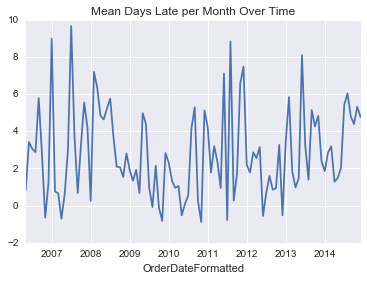

In [71]:
#Plots days late in a time series. Exhibit 1A, to be shared with team.

USMTO_NO_SUBMIT_BACKFILL.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line', title = 'Mean Days Late per Month Over Time')

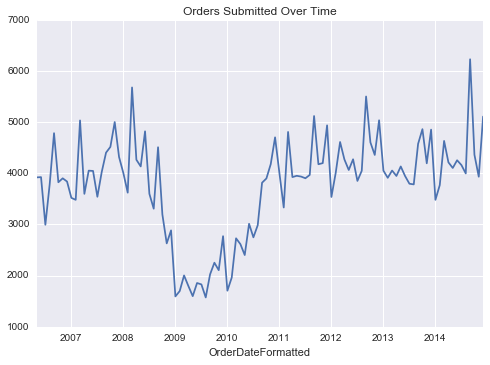

In [41]:
#plot order submission trend. Exhibit 2

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsSubmitted'].sum().plot(kind = 'line', title = 'Orders Submitted Over Time')

In [200]:
#shows clear connection between category and average days late
USMTO_WHOLE.groupby(['TopCategoryName'])['DaysLate'].mean()

TopCategoryName
METAL CUTTING EQUIPMENT                  13.583177
METAL FORMING & FABRICATING EQUIPMENT    20.811467
OTHER MFG. TECHNOLOGY                    31.818931
Name: DaysLate, dtype: float64

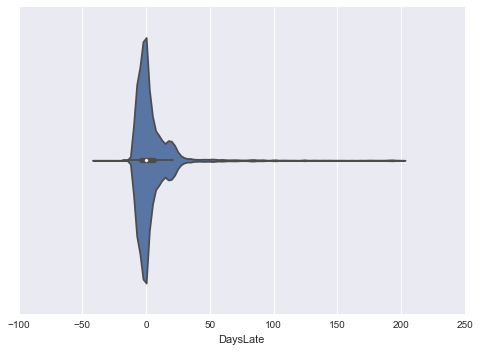

In [42]:
#plots distribution of days late

sns.violinplot(USMTO_NO_SUBMIT_OUTLIERS.DaysLate, title = 'Distribution of Days Late, 1997 to present')

In [198]:
#Creates table by AAID and OrderDateFormatted

AAID_BY_MONTH = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['DaysLate','TotalSale','IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill','Close','IP'].mean()
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2 = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['Units','TotalSale'].sum()
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH = AAID_BY_MONTH.merge(AAID_BY_MONTH_2, how = 'inner', on = ['AAID','OrderDateFormatted'])
AAID_BY_MONTH['TotalSaleAvg'] = AAID_BY_MONTH['TotalSale_x']
AAID_BY_MONTH['TotalSale'] = AAID_BY_MONTH['TotalSale_y']
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_x', axis = 1)
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_y', axis = 1)
AAID_BY_MONTH.head()

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,SubCategory,Units,TotalSaleAvg,TotalSale
0,123,2007-12-01,522.0,1,1,1,1,1468.359985,105.7256,7.615385,13,18461.538462,240000.0
1,123,2010-10-01,673.0,1,1,1,1,1183.260010,95.6362,29.000000,2,100000.000000,200000.0
2,100005,2006-05-01,-5.0,0,0,0,0,1270.089966,102.1531,2.000000,7,131438.714286,920071.0
3,100005,2006-06-01,1.0,1,0,0,0,1270.199951,102.5220,2.000000,2,153945.500000,307891.0
4,100005,2006-07-01,-8.0,0,0,0,0,1276.660034,102.5057,2.000000,11,57971.090909,637682.0


In [73]:
#gets rid of all observations that are backfills
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH[AAID_BY_MONTH.DaysLate <= 90]

In [74]:
AAID_BY_MONTH.describe()

,AAID,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale
count,16973.000000,16973.000000,16973.000000,16973.000000,16973.000000,16973.000000,16973.000000,16973.000000,16973.000000,1.697300e+04,1.697300e+04
mean,104107.072880,32.490308,0.459377,0.355152,0.274082,0.055382,1384.751438,99.681026,22.396335,2.404865e+05,3.491697e+06
std,8553.490515,180.195489,0.498362,0.478574,0.446064,0.228731,293.845865,4.946221,82.426205,4.384656e+05,8.050759e+06
min,123.000000,-39.000000,0.000000,0.000000,0.000000,0.000000,735.090027,87.412500,-7.000000,-2.639510e+06,-7.234735e+06
25%,100251.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,1186.689941,96.495900,3.000000,7.504458e+04,4.630582e+05
50%,100496.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1365.680054,101.038200,8.000000,1.424250e+05,1.269340e+06
75%,100704.000000,11.000000,1.000000,1.000000,1.000000,0.000000,1514.680054,103.494100,19.000000,2.673460e+05,3.121388e+06
max,123556.000000,3190.000000,1.000000,1.000000,1.000000,1.000000,2067.560059,106.686800,1867.000000,1.700000e+07,1.212488e+08


In [75]:
AAID_BY_MONTH['SalesIndex'] = AAID_BY_MONTH['TotalSale']*100/349169.7

In [76]:
AAID_BY_MONTH['AvgSalesIndex'] = AAID_BY_MONTH['TotalSaleAvg']*100/240486.5

In [77]:
AAID_BY_MONTH.head()

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale,SalesIndex,AvgSalesIndex
0,123,2007-12-01,522.0,1,1,1,1,1468.359985,105.7256,13,18461.538462,240000.0,68.734486,7.676746
1,123,2010-10-01,673.0,1,1,1,1,1183.260010,95.6362,2,100000.000000,200000.0,57.278739,41.582376
2,100005,2006-05-01,-5.0,0,0,0,0,1270.089966,102.1531,7,131438.714286,920071.0,263.502532,54.655340
3,100005,2006-06-01,1.0,1,0,0,0,1270.199951,102.5220,2,153945.500000,307891.0,88.178041,64.014196
4,100005,2006-07-01,-8.0,0,0,0,0,1276.660034,102.5057,11,57971.090909,637682.0,182.628103,24.105757


In [82]:
AAID_BY_MONTH = AAID_BY_MONTH[AAID_BY_MONTH.AAID != 123]

In [83]:
AAID_BY_MONTH.head()

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale,SalesIndex,AvgSalesIndex
2,100005,2006-05-01,-5.0,0,0,0,0,1270.089966,102.1531,7,131438.714286,920071.0,263.502532,54.655340
3,100005,2006-06-01,1.0,1,0,0,0,1270.199951,102.5220,2,153945.500000,307891.0,88.178041,64.014196
4,100005,2006-07-01,-8.0,0,0,0,0,1276.660034,102.5057,11,57971.090909,637682.0,182.628103,24.105757
5,100005,2006-08-01,15.0,1,1,1,0,1303.819946,102.8357,1,65994.000000,65994.0,18.900265,27.441873
6,100005,2006-10-01,3.0,1,0,0,0,1377.939941,102.6297,1,106348.000000,106348.0,30.457397,44.222025


In [89]:
AAID_BY_MONTH.AAID.nunique()

286

In [95]:
AAID_BY_MONTH.OrderDateFormatted.nunique()

104

In [97]:
AAID_BY_MONTH.OrderDateFormatted.unique()

array(['2006-04-30T20:00:00.000000000-0400',
       '2006-05-31T20:00:00.000000000-0400',
       '2006-06-30T20:00:00.000000000-0400',
       '2006-07-31T20:00:00.000000000-0400',
       '2006-09-30T20:00:00.000000000-0400',
       '2006-10-31T20:00:00.000000000-0400',
       '2006-11-30T19:00:00.000000000-0500',
       '2006-12-31T19:00:00.000000000-0500',
       '2007-01-31T19:00:00.000000000-0500',
       '2007-02-28T19:00:00.000000000-0500',
       '2007-03-31T20:00:00.000000000-0400',
       '2007-04-30T20:00:00.000000000-0400',
       '2007-05-31T20:00:00.000000000-0400',
       '2007-06-30T20:00:00.000000000-0400',
       '2007-07-31T20:00:00.000000000-0400',
       '2007-08-31T20:00:00.000000000-0400',
       '2007-09-30T20:00:00.000000000-0400',
       '2007-10-31T20:00:00.000000000-0400',
       '2007-11-30T19:00:00.000000000-0500',
       '2007-12-31T19:00:00.000000000-0500',
       '2008-01-31T19:00:00.000000000-0500',
       '2008-02-29T19:00:00.000000000-0500',
       '20

In [92]:
AAID_BY_MONTH.AAID.unique()

array([100005, 100009, 100010, 100014, 100024, 100027, 100034, 100035,
       100045, 100046, 100047, 100048, 100051, 100058, 100059, 100062,
       100066, 100073, 100074, 100075, 100076, 100079, 100085, 100103,
       100116, 100120, 100123, 100128, 100129, 100132, 100135, 100141,
       100144, 100147, 100149, 100160, 100162, 100165, 100174, 100175,
       100178, 100180, 100182, 100189, 100191, 100196, 100197, 100203,
       100207, 100213, 100225, 100227, 100228, 100230, 100246, 100251,
       100257, 100259, 100271, 100279, 100284, 100286, 100290, 100292,
       100294, 100304, 100309, 100313, 100316, 100317, 100318, 100321,
       100325, 100329, 100331, 100332, 100333, 100338, 100339, 100340,
       100346, 100353, 100359, 100361, 100362, 100370, 100374, 100383,
       100389, 100393, 100395, 100396, 100400, 100401, 100409, 100412,
       100413, 100414, 100417, 100425, 100427, 100428, 100432, 100435,
       100444, 100448, 100473, 100485, 100490, 100493, 100495, 100496,
      

In [106]:
AAID_BY_MONTH.groupby('AAID')['TotalSale'].max().head()

AAID
100005    1937146.0
100009    8383273.0
100010    7137487.0
100014    8114460.0
100024    9564089.0
Name: TotalSale, dtype: float64

In [115]:
AAID_BY_MONTH.groupby('AAID')['SalesIndex'].max().head()

AAID
100005     554.786398
100009    2400.916517
100010    2044.131263
100014    2323.930169
100024    2739.094773
Name: SalesIndex, dtype: float64

In [121]:
AAID_MAX = AAID_BY_MONTH.groupby('AAID')['SalesIndex'].max()

In [122]:
AAID_MAX.head()

AAID
100005     554.786398
100009    2400.916517
100010    2044.131263
100014    2323.930169
100024    2739.094773
Name: SalesIndex, dtype: float64

In [123]:
AAID_MAX.describe()

count      286.000000
mean      2572.042421
std       4696.445751
min          1.255550
25%        504.454854
50%       1125.844826
75%       2365.931234
max      34724.886655
Name: SalesIndex, dtype: float64

In [134]:
AAID_BY_MONTH['MaxSalesIndex'] = AAID_BY_MONTH.groupby('AAID')['SalesIndex'].max()
AAID_BY_MONTH.head(20)

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale,SalesIndex,AvgSalesIndex,MaxSalesIndex
2,100005,2006-05-01,-5.0,0,0,0,0,1270.089966,102.1531,7,131438.714286,920071.00,263.502532,54.655340,NaN
3,100005,2006-06-01,1.0,1,0,0,0,1270.199951,102.5220,2,153945.500000,307891.00,88.178041,64.014196,NaN
4,100005,2006-07-01,-8.0,0,0,0,0,1276.660034,102.5057,11,57971.090909,637682.00,182.628103,24.105757,NaN
5,100005,2006-08-01,15.0,1,1,1,0,1303.819946,102.8357,1,65994.000000,65994.00,18.900265,27.441873,NaN
6,100005,2006-10-01,3.0,1,0,0,0,1377.939941,102.6297,1,106348.000000,106348.00,30.457397,44.222025,NaN
7,100005,2006-11-01,-3.0,0,0,0,0,1400.630005,102.5390,15,129143.066667,1937146.00,554.786398,53.700755,NaN
8,100005,2006-12-01,-7.0,0,0,0,0,1418.300049,103.6229,1,66360.000000,66360.00,19.005085,27.594065,NaN
9,100005,2007-01-01,-9.0,0,0,0,0,1438.239990,103.1171,4,19974.502500,79898.01,22.882286,8.305873,NaN
10,100005,2007-02-01,-5.0,0,0,0,0,1406.819946,104.1720,6,85525.666667,513154.00,146.964069,35.563604,NaN
11,100005,2007-03-01,2.0,1,0,0,0,1420.859985,104.3501,2,157502.500000,315005.00,90.215445,65.493281,NaN


In [135]:
AAID_BY_MONTH = AAID_BY_MONTH.drop('MaxSalesIndex', axis=1)

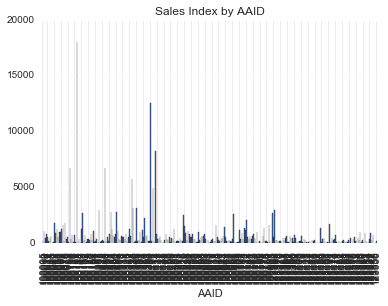

In [139]:
AAID_BY_MONTH.groupby(['AAID'])['SalesIndex'].mean().plot(kind = 'bar', align='center', title = 'Sales Index by AAID')

In [147]:
AAID_BY_MONTH.sort_values('SalesIndex', ascending=False).head(20)

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale,SalesIndex,AvgSalesIndex
2237,100132,2014-09-01,3.0,1,0,0,0,1972.290039,105.5750,1658,7.103034e+04,1.212488e+08,34724.886655,29.536101
2216,100132,2012-12-01,-6.0,0,0,0,0,1426.189941,101.0382,1492,7.643153e+04,1.170931e+08,33534.727257,31.782047
2162,100132,2008-06-01,4.0,1,0,0,0,1280.000000,103.3216,1575,6.703345e+04,1.087953e+08,31158.286655,27.874103
2159,100132,2008-03-01,5.0,1,1,0,0,1322.699951,104.7987,1867,5.761492e+04,1.075671e+08,30806.527207,23.957653
2213,100132,2012-09-01,-5.0,0,0,0,0,1440.670044,99.9599,1433,7.480019e+04,1.071887e+08,30698.161272,31.103698
7665,100413,2011-09-01,480.0,1,1,1,1,1131.420044,97.7474,339,3.087862e+05,1.046785e+08,29979.271397,128.400650
2201,100132,2011-09-01,-3.0,0,0,0,0,1131.420044,97.7474,1345,7.298995e+04,9.817149e+07,28115.695096,30.350957
7309,100400,2011-07-01,-2.0,0,0,0,0,1292.280029,97.3169,349,2.473859e+05,9.672790e+07,27702.260534,102.868948
2217,100132,2013-01-01,1.0,1,0,0,0,1498.109985,100.9614,1231,7.705971e+04,9.640169e+07,27608.837184,32.043257
2214,100132,2012-10-01,-2.0,0,0,0,0,1412.160034,100.2146,1161,7.854866e+04,9.339436e+07,26747.555604,32.662400


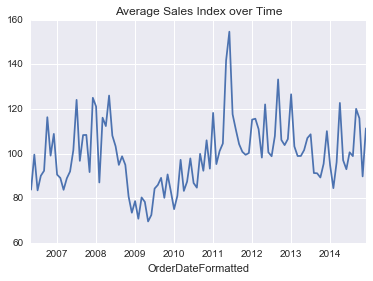

In [153]:
AAID_BY_MONTH.groupby(['OrderDateFormatted'])['AvgSalesIndex'].mean().plot(kind = 'line', title = 'Average Sales Index over Time')

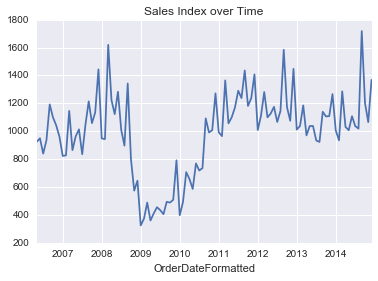

In [154]:
AAID_BY_MONTH.groupby(['OrderDateFormatted'])['SalesIndex'].mean().plot(kind = 'line', title = 'Sales Index over Time')

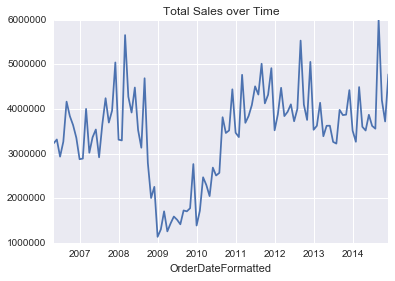

In [155]:
#shows that the index still is showing the same information
AAID_BY_MONTH.groupby(['OrderDateFormatted'])['TotalSale'].mean().plot(kind = 'line', title = 'Total Sales over Time')

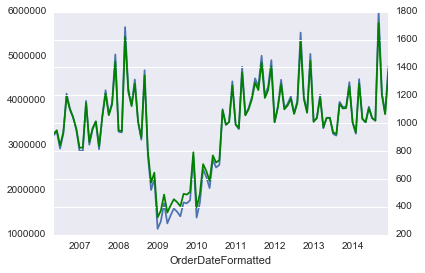

In [183]:
#shows that the index is showing the same information
AAID_BY_MONTH.groupby(['OrderDateFormatted'])['TotalSale'].mean().plot(kind = 'line')
AAID_BY_MONTH.groupby(['OrderDateFormatted'])['SalesIndex'].mean().plot(kind = 'line', secondary_y=True, style= 'g')

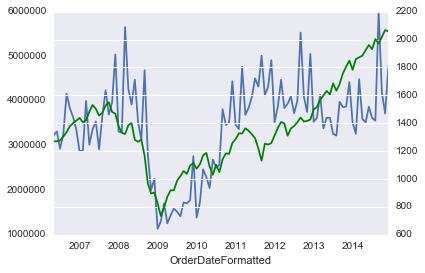

In [180]:
#shows a basic correlation between S&P close data and USMTO
AAID_BY_MONTH.groupby(['OrderDateFormatted'])['TotalSale'].mean().plot(kind = 'line')
AAID_BY_MONTH.groupby(['OrderDateFormatted'])['Close'].mean().plot(kind = 'line', secondary_y=True, style= 'g')

In [158]:
AAID_BY_MONTH.sort_values('SalesIndex').max()

AAID                               123556
OrderDateFormatted    2014-12-01 00:00:00
DaysLate                             3190
IsEmailOne                              1
IsEmailTwo                              1
IsCall                                  1
IsBackfill                              1
Close                             2067.56
IP                                106.687
Units                                1867
TotalSaleAvg                      1.7e+07
TotalSale                     1.21249e+08
SalesIndex                        34724.9
AvgSalesIndex                        7069
dtype: object

In [171]:
AAID_BY_MONTH.groupby('AAID')['SalesIndex'].nlargest(1)

AAID         
100005  7          554.786398
100009  162       2400.916517
100010  270       2044.131263
100014  353       2323.930169
100024  414       2739.094773
100027  506       1621.171597
100034  597       2465.465156
100035  628       1325.372734
100045  639         37.231180
100046  672        690.407845
100047  807      11775.454316
100048  875       4021.866158
100051  1007      4696.551849
100058  1038      1379.438708
100059  1158      3546.841837
100062  1261      3794.702189
100066  1279      2447.863603
100073  1373      7847.138512
100074  1404       294.842307
100075  1481      6364.233767
100076  1531      1012.295457
100079  1621      1752.729403
100085  1651       708.956708
100103  1803     21707.308223
100116  1884      1014.655624
100120  1923       692.878563
100123  1924       359.719715
100128  2049      2138.969962
100129  2133       418.478465
100132  2237     34724.886655
                     ...     
123484  16516      850.869958
123485  16544      868.039

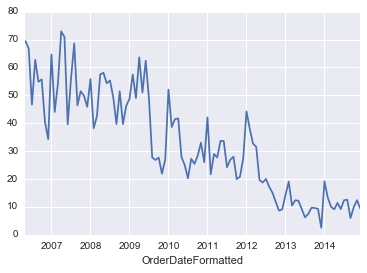

In [181]:
#includes backfills so this is probably messed up
AAID_BY_MONTH.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line')